# Uncertainty Disentanglement 

Disentangling Epistemic and Aleatoric Uncertainty in
Reinforcement Learning

In [366]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm

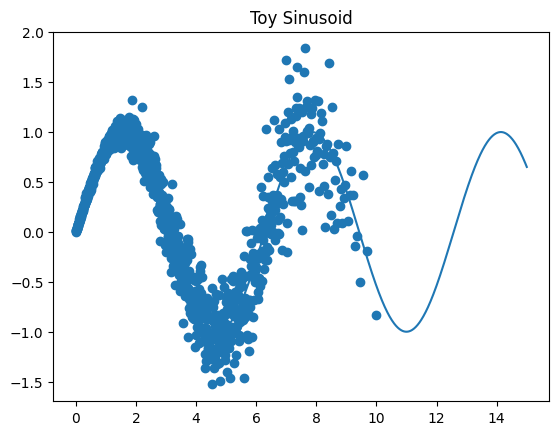

In [367]:
torch.manual_seed(0)

# Generate Training Data
N, M, D, A = 1000, 10, 5, 0.05

X = (10-torch.linspace(0,100,N) ** 0.5).sort()[0].unsqueeze(1)
Y = (torch.sin(X)+torch.randn_like(X) * A * X)
#Y = (torch.sin(X)+torch.randn_like(X) * A)

X_all = torch.linspace(0,D*3, 1000).unsqueeze(1)
Y_all = torch.sin(X_all)

fig, ax = plt.subplots()
ax.scatter(X,Y)
ax.set_title("Toy Sinusoid")
ax.plot(X_all, Y_all)

100%|██████████| 1000/1000 [00:02<00:00, 436.50it/s]


Text(0.5, 1.0, 'Epistemic')

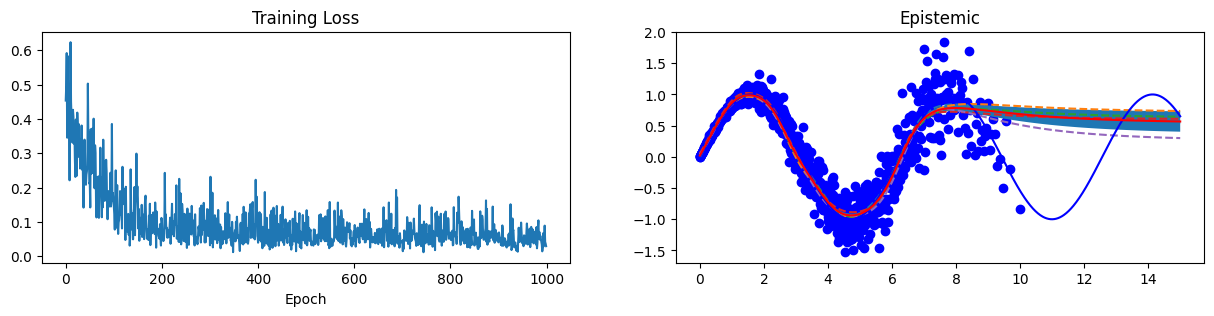

In [368]:
# Disagreement with MSE prediction
torch.manual_seed(0)

N_ENSEMBLE = 5
N_EPOCH = 1000

mse_ensemble = [
    nn.Sequential(
        nn.Linear(1, 32),
        nn.Tanh(),
        nn.Linear(32,32),
        nn.Tanh(),
        nn.Linear(32,1)
    )
    for _ in range(N_ENSEMBLE)
]

optim_mse = torch.optim.Adam(nn.ModuleList(mse_ensemble).parameters(), lr=0.01)

debug_loss = []

for epoch in tqdm(range(N_EPOCH)):
    batch = torch.randint(0, N, size=(32,))
    Y_p = torch.stack([e(X[batch]) for e in mse_ensemble])
    optim_mse.zero_grad()
    loss = torch.mean((Y_p - Y[batch].unsqueeze(0))**2)
    loss.backward()
    debug_loss.append(loss.item())
    optim_mse.step()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,3)
# Training Loss
axs[0].plot(debug_loss)
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")

Y_p = torch.stack([e(X_all) for e in mse_ensemble]).squeeze()
variance = torch.var(Y_p, dim=0).detach().cpu().numpy()
mean = torch.mean(Y_p, dim=0).detach().cpu().numpy()
axs[1].scatter(X.squeeze(),Y.squeeze(), color="b")
for y_p in Y_p:
    axs[1].plot(X_all, y_p.detach().cpu().numpy(), "--")
axs[1].plot(X_all, Y_all, color="b")
axs[1].plot(X_all, mean, color="r")
axs[1].fill_between(X_all.squeeze(), mean-variance**0.5,mean+variance**0.5)
axs[1].set_title("Epistemic")

100%|██████████| 1000/1000 [00:02<00:00, 387.75it/s]


Text(0.5, 1.0, 'Aleatoric')

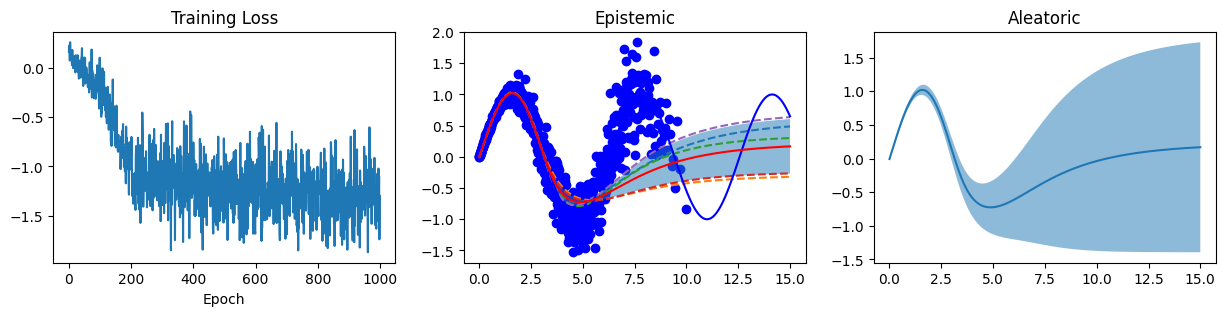

In [369]:
# Disagreement with NLL prediction
torch.manual_seed(0)

N_ENSEMBLE = 5
N_EPOCH = 1000

nll_ensemble = [
    nn.Sequential(
        nn.Linear(1, 32),
        nn.Tanh(),
        nn.Linear(32,32),
        nn.Tanh(),
        nn.Linear(32,2)
    )
    for _ in range(N_ENSEMBLE)
]

optim_nll = torch.optim.Adam(nn.ModuleList(nll_ensemble).parameters(), lr=0.001)
softplus = nn.Softplus()

debug_loss = []

for epoch in tqdm(range(N_EPOCH)):
    batch = torch.randint(0, N, size=(32,))
    Y_p = torch.stack([e(X[batch]) for e in nll_ensemble])
    mu = Y_p[:,:,0].unsqueeze(-1)
    sigma = softplus(Y_p[:,:,1].unsqueeze(-1))
    optim_nll.zero_grad()
    loss = torch.mean(torch.log(sigma) / 2 + (Y[batch].unsqueeze(0) - mu)**2 / (2* sigma))
    loss.backward()
    debug_loss.append(loss.item())
    optim_nll.step()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,3)
# Training Loss
axs[0].plot(debug_loss)
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")

Y_p = torch.stack([e(X_all) for e in nll_ensemble])[:,:,0].squeeze()
aleatoric = torch.mean(torch.stack([softplus(e(X_all)) for e in nll_ensemble])[:,:,1].squeeze(), dim=0).detach().cpu().numpy()
variance = torch.var(Y_p, dim=0).detach().cpu().numpy()
mean = torch.mean(Y_p, dim=0).detach().cpu().numpy()
axs[1].scatter(X.squeeze(),Y.squeeze(), color="b")
for y_p in Y_p:
    axs[1].plot(X_all, y_p.detach().cpu().numpy(), "--")
axs[1].plot(X_all, Y_all, color="b")
axs[1].plot(X_all, mean, color="r")
axs[1].fill_between(X_all.squeeze(), mean-variance**0.5,mean+variance**0.5, alpha=0.5)
axs[1].set_title("Epistemic")


axs[2].plot(X_all, mean)
axs[2].fill_between(X_all.squeeze(), mean-aleatoric**0.5, mean+aleatoric**0.5, alpha=0.5)
axs[2].set_title("Aleatoric")

100%|██████████| 1000/1000 [00:02<00:00, 391.82it/s]


Text(0.5, 1.0, 'Aleatoric')

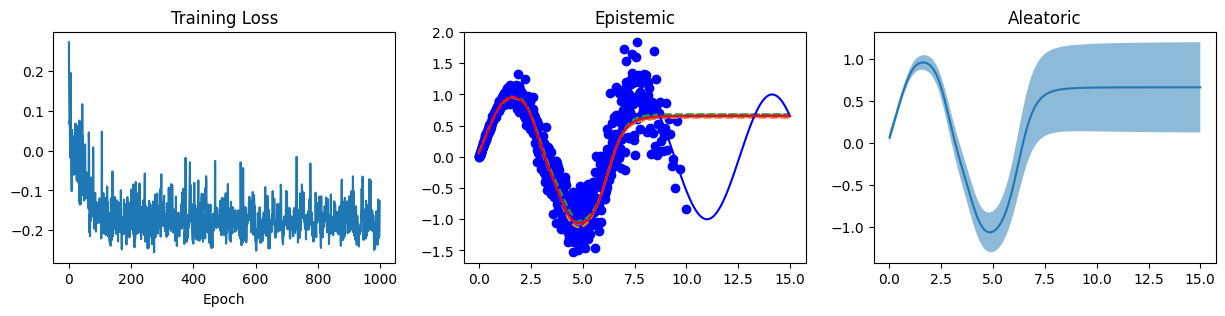

In [370]:
# Disagreement with bNLL prediction
torch.manual_seed(1)

N_ENSEMBLE = 5
N_EPOCH = 1000

bnll_ensemble = [
    nn.Sequential(
        nn.Linear(1, 32),
        nn.Tanh(),
        nn.Linear(32,32),
        nn.Tanh(),
        nn.Linear(32,2)
    )
    for _ in range(N_ENSEMBLE)
]

beta = 0.5
optim_bnll = torch.optim.Adam(nn.ModuleList(bnll_ensemble).parameters(), lr=0.01)
softplus = nn.Softplus()

debug_loss = []

for epoch in tqdm(range(N_EPOCH)):
    batch = torch.randint(0, N, size=(32,))
    Y_p = torch.stack([e(X[batch]) for e in bnll_ensemble])
    mu = Y_p[:,:,0].unsqueeze(-1)
    sigma = softplus(Y_p[:,:,1].unsqueeze(-1))
    optim_bnll.zero_grad()
    sigma_beta = (sigma**beta).detach()
    loss = torch.log(sigma) / 2 + (Y[batch].unsqueeze(0) - mu)**2 / (2* sigma)
    loss = loss * sigma_beta
    loss = torch.mean(loss)
    loss.backward()
    debug_loss.append(loss.item())
    optim_bnll.step()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,3)
# Training Loss
axs[0].plot(debug_loss)
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")

Y_p = torch.stack([e(X_all) for e in bnll_ensemble])[:,:,0].squeeze()
aleatoric = torch.mean(torch.stack([softplus(e(X_all)) for e in bnll_ensemble])[:,:,1].squeeze(), dim=0).detach().cpu().numpy()
variance = torch.var(Y_p, dim=0).detach().cpu().numpy()
mean = torch.mean(Y_p, dim=0).detach().cpu().numpy()
axs[1].scatter(X.squeeze(),Y.squeeze(), color="b")
for y_p in Y_p:
    axs[1].plot(X_all, y_p.detach().cpu().numpy(), "--")
axs[1].plot(X_all, Y_all, color="b")
axs[1].plot(X_all, mean, color="r")
axs[1].fill_between(X_all.squeeze(), mean-variance**0.5,mean+variance**0.5, alpha=0.5)
axs[1].set_title("Epistemic")

axs[2].plot(X_all, mean)
axs[2].fill_between(X_all.squeeze(), mean-aleatoric**0.5, mean+aleatoric**0.5, alpha=0.5)
axs[2].set_title("Aleatoric")